# RNSA Bone Age 
Fine-tuned pre-trained ResNet18, including both image and gender inputs

In [0]:
import pandas as pd
import numpy as np
import math
import random
import itertools
import pickle

from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# !pip uninstall -y tensorflow
# !pip install tensorflow-gpu==1.14.0 
# !pip install -U --force-reinstall --no-dependencies git+https://github.com/datumbox/keras@bugfix/trainable_bn 
from keras import backend as K
from keras import layers, models, regularizers, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout, concatenate
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.preprocessing import image as krs_image
from keras.optimizers import Adam

from classification_models.keras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'SHARED_LINK_ID'}) 
downloaded.GetContentFile('train.csv')  

In [0]:
downloaded = drive.CreateFile({'id':'SHARED_LINK_ID'}) 
downloaded.GetContentFile('test.csv')  

In [0]:
train_val = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

In [0]:
train, val = train_test_split(train_val.copy(), test_size=0.2, random_state=2020)

In [0]:
train.shape, val.shape, test.shape

((10088, 3), (2523, 3), (200, 3))

## Descriptives of dataset

In [0]:
train['gender'] = train.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)
val['gender'] = val.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)
test['gender'] = test.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)

### Age Distributions

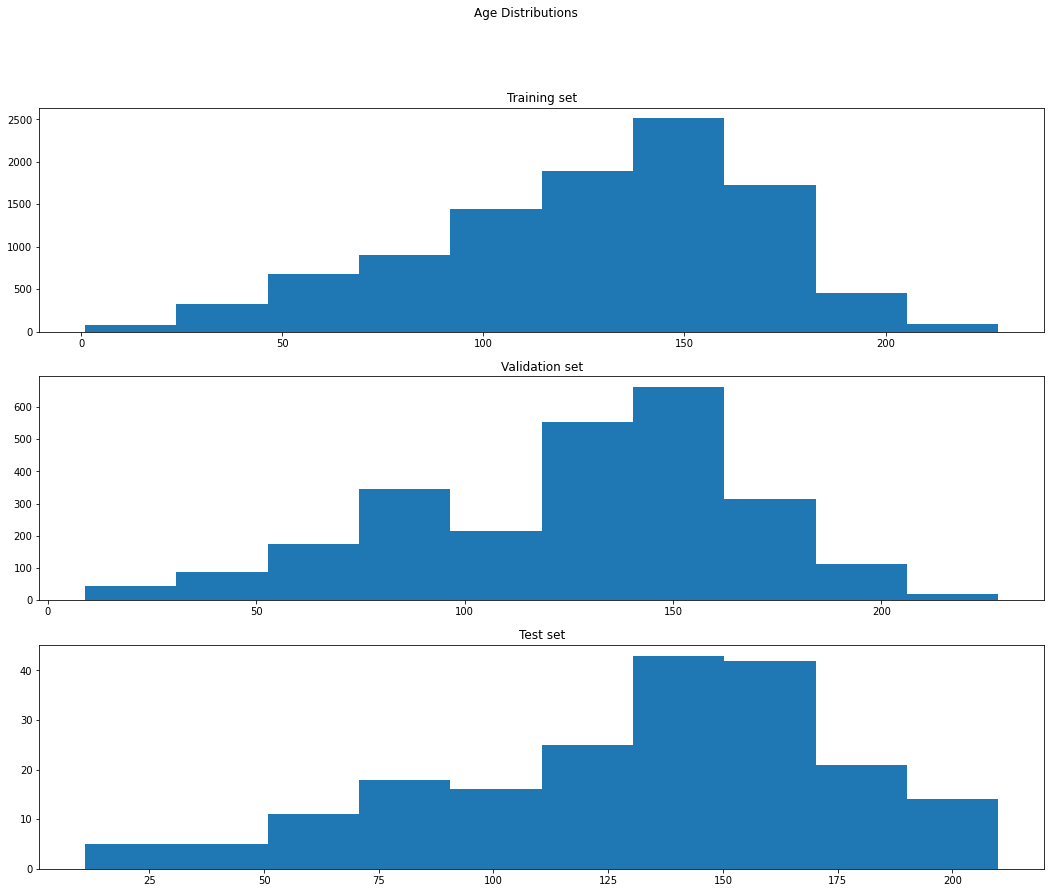

In [0]:
fig = plt.figure(figsize=(18,14)) 
fig_dims = (3, 1)
fig.suptitle('Age Distributions')

plt.subplot2grid(fig_dims, (0, 0))
plt.hist(train['boneage'])
plt.title('Training set')

plt.subplot2grid(fig_dims, (1, 0))
plt.hist(val['boneage'])
plt.title('Validation set')

plt.subplot2grid(fig_dims, (2, 0))
plt.hist(test['boneage'])
plt.title('Test set');


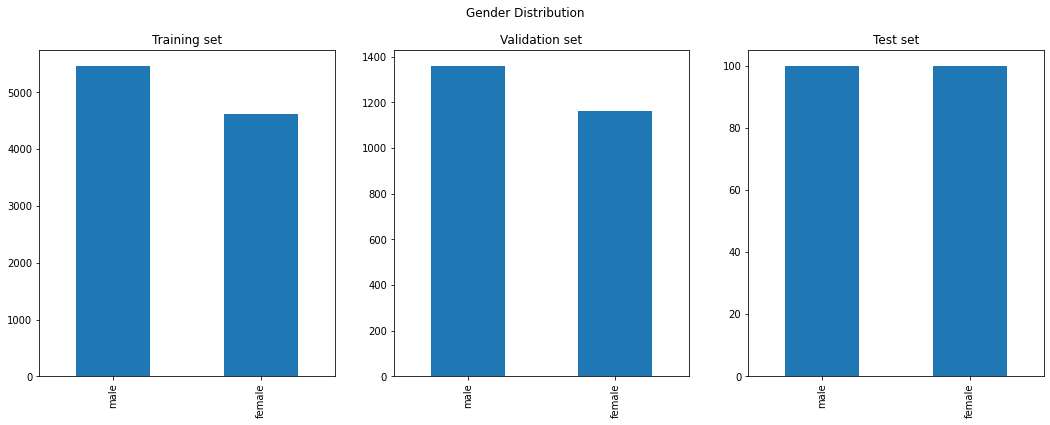

In [0]:
fig = plt.figure(figsize=(18,6)) 
fig_dims = (1, 3)
fig.suptitle('Gender Distribution')

plt.subplot2grid(fig_dims, (0, 0))
train['gender'].value_counts().plot(kind='bar', title='Training set');

plt.subplot2grid(fig_dims, (0, 1))
val['gender'].value_counts().plot(kind='bar', title='Validation set');

plt.subplot2grid(fig_dims, (0, 2))
test['gender'].value_counts().plot(kind='bar', title='Test set');

## Gender

In [0]:
train['is_male'] = train.apply(lambda row: 1 if row['male']==True else 0, axis=1)
val['is_male'] = val.apply(lambda row: 1 if row['male']==True else 0, axis=1)
test['is_male'] = test.apply(lambda row: 1 if row['male']==True else 0, axis=1)

## Upload images from drive

In [0]:
download = drive.CreateFile({'id': 'SHARED_LINK_ID'})
download.GetContentFile('resized-padded.zip')

In [0]:
!unzip -q 'resized-padded.zip'

### Add Image Path to dataframes

In [0]:
train['img_path'] = 'resized_padded/training/' + train['img_path']
val['img_path'] = 'resized_padded/training/' + val['img_path']
test['img_path'] = 'resized_padded/test/' + test['img_path']

## Custom Data Generator to load Image and Gender data

Code was inspired by: https://stackoverflow.com/questions/55266249/create-a-mixed-data-generator-images-csv-in-keras

In [0]:
def custom_generator(df, batch_size, datagen, split, shuffle=True):
  """
  Generator for both image and gender input.
  Takes as input a dataframe with information on image path, gender and bone age, an empty keras ImageDataGenerator 
  and the split as a string (e.g., 'train', 'val', 'test')
  """
    i = 0
    image_ids = list(df.index)
    if shuffle:    
        random.shuffle(image_ids)
    while True:
        batch = {'images': [], 'gender': [], 'labels': []}
        for b in range(batch_size):
            if i == len(image_ids):
                i = 0
                if shuffle:
                    random.shuffle(image_ids)
                break
            
            # Read image from list and convert to array
            image_path = df.loc[image_ids[i], 'img_path']
            image = krs_image.load_img(image_path, target_size=(256, 256))
            image = krs_image.img_to_array(image)
            image = preprocess_input(image)

            # Random transformations for training set
            if split=='train':
                train_datagen_args = dict(
                                      theta=random.randint(0, 20), 
                                      tx=random.randint(-20, 20), 
                                      ty=random.randint(-20, 20),
                                      zx=random.uniform(0.8, 1),
                                      zy=random.uniform(0.8, 1),
                                      flip_horizontal=np.random.choice([True, False]),
                                  )
                image = datagen.apply_transform(image, transform_parameters=train_datagen_args)

            # Read data from csv using the name of current image
            gender = df.loc[image_ids[i], 'is_male']
            label = df.loc[image_ids[i], 'boneage']

            batch['images'].append(image)
            batch['gender'].append(gender)
            batch['labels'].append(label)

            i += 1
        
        batch['images'] = np.array(batch['images'])
        batch['gender'] = np.array(batch['gender'])
        batch['labels'] = np.array(batch['labels'])
        
        yield [batch['images'], batch['gender']], batch['labels']

In [0]:
# Create an empty data generator
datagen = ImageDataGenerator()

In [0]:
train_generator = custom_generator(train, 64, datagen, 'train')
val_generator = custom_generator(val, 64, datagen, 'val')
test_generator = custom_generator(test, 200, datagen, 'test')

## Deep Learning


### Baseline

As in initial baseline for the regression model, we can look at a central tendency measure of the validation set. In this case, we will use the mean of the validation set as the initial baseline.

In [0]:
mean_validation_set = np.mean(val.boneage)
y_pred = np.array(len(val.boneage) * [mean_validation_set])
y_true = val.boneage
baseline_mae = mean_absolute_error(y_true, y_pred)
baseline_mse = mean_squared_error(y_true, y_pred)
print('The initial baseline for the problem is a Mean Absolute Error of {} months.'.format(round(baseline_mae,2)))
print('The initial baseline for the problem is a Mean Squared Error of {}.'.format(round(baseline_mse,2)))

The initial baseline for the problem is a Mean Absolute Error of 33.68 months.
The initial baseline for the problem is a Mean Squared Error of 1683.65.


A more domain-based baseline for this project would be the MAE of pediatric
radiologists. Reddy et al. (2019) have conducted an experiment with three radiologists on the RSNA bone age dataset. The authors found a Mean Absolute Error of 6.0 months for radiologist on the RSNA bone age dataset.

__Reference__

Reddy, N. E., Rayan, J. C., Annapragada, A. V., Mahmood, N. F., Scheslinger, A. E., Zhang, W., & Kan, J. H. (2020). Bone age determination using only the index finger: a novel approach using a convolutional neural network compared with human radiologists. _Pediatric Radiology_, 50(4), 516-523.

### Fine-tuned pre-trained model

For this research, I employ a model with two inputs, namely image data and gender. For the gender input, I use one dense hidden layer with 8 neurons. For the image model, I use a pre-trained (fine-tuned) ResNet18 model. Outputs of these models are then concatenated and fed through one dense hidden layer to allow the model to to reason out the relationship between the pixel and gender information (Cicero & Bilbily, 2017).

Based on the paper by Sarić et al. (2019), where a fine-tuned ResNet50 model is employed for the task of bone age prediction on the RSNA dataset, I use the Adam optimizer. For tuning, I consider the number of fine-tuned (i.e., unfrozen layers) in the ResNet18 architecture, the number of hidden neurons in the dense hidden layer after the concatenated layer and the learning rate. 

Cicero, M., & Bilbily, A. (2017). Machine Learning and the Future of Radiology: How we won the 2017 RSNA ML Challenge. Retrieved from https://www.16bit.ai/blog/ml-and-future-of-radiology

Sarić, R., Kevrić, J., Čustović, E., Jokić, D., & Beganović, N. (2019). Evaluation of Skeletal Gender and Maturity for Hand Radiographs using Deep Convolutional Neural Networks. In 2019 6th International Conference on Control, Decision and Information Technologies (CoDIT) (pp. 1115-1120). IEEE.

In [0]:
def build_model(trainable='none',
                dense_hidden_neurons=16,
                lr=0.001):
    """
    Builds a model with incorporated ResNet18 to handle image input and a dense layer for gender input.
    Arguments:
    - trainable: number of trainable layers in ResNet18. One of:
        - 'last_conv_layer'
        - 'stage4_unit_2'
    - dense_hidden_neurons: number of hidden neurons in the last hidden layer after concatenation of gender and 
    image networks.
    - lr: learning rate
    """
    ## MLP
    # define our MLP network for the gender input
    mlp = Sequential()
    mlp.add(Dense(8, input_dim=1, activation="relu"))
  
    ## ResNet18
    # Instantiate ResNet18 model trained on imagenet
    pre_trained_model = ResNet18(weights='imagenet', 
                                 include_top=False,
                                 input_shape=(256, 256, 3))
  
    # If layers must be set to trainable, do that here
    if trainable=='last_conv_layer':
        from_trainable = -7

    elif trainable=='stage4_unit2':
        from_trainable = -11
  
    else: 
        from_trainable = len(pre_trained_model.layers)

    # Set layers to trainable
    for layer in pre_trained_model.layers[from_trainable:]: 
        layer.trainable = True
    # Freeze all other layers
    for layer in pre_trained_model.layers[:from_trainable]: 
        layer.trainable = False

    # Add a Global Average Pooling layer to reduce the number of parameters in the model
    pooling = layers.GlobalAveragePooling2D()(pre_trained_model.output)

    # Build new model structure
    resnet_50 = Model(inputs=pre_trained_model.input, outputs=pooling)

    # Concatenate
    combined_input = concatenate([mlp.output, resnet_50.output])
    add_layer = Dense(dense_hidden_neurons, activation='relu', kernel_regularizer=regularizers.l2(0.1))(combined_input)

    # Add output layer for regression
    output_layer = Dense(1, activation='linear')(add_layer)

    # Final model
    model = Model(inputs=[resnet_50.input, mlp.input], outputs=output_layer)

    optim = Adam(lr=lr)

    model.compile(optimizer=optim,
                  loss='mse',
                  metrics=['mae'])

    return model

In [0]:
model = build_model()








44924928/44920640 [==============================] - 2s 0us/step



In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

### Manual Tuning

Because of computational restrictions due to resource constraints, I could not do any structured hyperparameter tuning (e.g., grid search, hyperopt). Therefore, I did some manual tuning on the following three hyperparameters:
* layers trainable in pre-trained model
* dense hidden neurons in last dense hidden layer
* learning rate

For most other untuned hyperparameters, I use values that are stated in academic papers on the RSNA Bone Age dataset.

In [0]:
def fit_model(model, epochs=20, verbose=2):
    """
    Fits model on train_generator and validates on val_generator. 
    Takes as input:
    - model: model to train
    - epochs: number of epochs
    - verbose: verbosity of fit_generator
    """
    early_stopping = EarlyStopping(monitor='val_mean_absolute_error', patience=10)

    checkpointer = ModelCheckpoint(filepath='keras_weights_{}.hdf5'.format(model.name),
                                   monitor='val_mean_absolute_error', 
                                   verbose=0, 
                                   save_best_only=True)

    callbacks = [early_stopping, checkpointer]
    return model.fit_generator(train_generator,
                               epochs=epochs,
                               validation_data=val_generator,
                               steps_per_epoch=math.ceil(len(train)/64),
                               validation_steps=math.ceil(len(val)/64),
                               callbacks=callbacks,
                               verbose=verbose)

In [0]:
def plot_history(history):
    """
    Plot train/validation MAE and train/validation loss (MSE) of trained model.
    Takes as input the history.history dictionary of a trained model. 
    """    
    mae = history['mean_absolute_error']
    val_mae = history['val_mean_absolute_error']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(mae)+1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle('Training and Validation MAE and Loss')

    ax1.plot(epochs, mae)
    ax1.plot(epochs, val_mae)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MAE')
    ax1.set_title('MAE')
    ax1.legend(['training', 'validation'])

    ax2.plot(epochs, loss)
    ax2.plot(epochs, val_loss)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss')
    ax2.legend(['training', 'validation'])

#### Define search space

In [0]:
trainable = ['none', 'last_conv_layer', 'stage4_unit2']
dense_hidden_neurons = [16, 32]
lr = [0.001, 0.0001]

search_space = [{'trainable': train,
                 'dense_hidden_neurons': neurons,
                 'lr': learning_rate} 
                for train, neurons, learning_rate in list(itertools.product(trainable, dense_hidden_neurons, lr))]

trained_models = {'model_{}'.format(i+1): {'params': search_space[i],
                                   'result': None} 
                  for i in range(len(search_space))}

In [0]:
def train_and_save(model_nr, epochs=20):
    """
    Trains one of the models with parameters within the search space and downloads results (hdf5 file with model 
    and weights and dictionary with trained_models and history of trained models so far) to local PC.
    Takes as input:
    - model_nr: the number of de model as defined above that we are trained
    - epochs: number of epochs for fit_model
    """
    model = build_model(**trained_models[model_nr]['params'])
    model.name = model_nr
    history = fit_model(model, epochs=epochs)
    files.download('keras_weights_{}.hdf5'.format(model_nr))

    trained_models[model_nr]['result'] = history.history

    with open('{}.pickle'.format(model_nr), 'wb') as file:
        pickle.dump(trained_models, file)

    files.download('{}.pickle'.format(model_nr))
    return trained_models

In [0]:
def model_params_results(model_nr):
    """
    Prints results (parameters, best validation loss and best MAE) of a trained model
    """
    print('Parameters of {}:'.format(model_nr), trained_models[model_nr]['params'])
    print('Best validation loss loss of {}:'.format(model_nr), 
          round(np.min(trained_models[model_nr]['result']['val_loss']), 2))
    print('Best validation MAE of {}:'.format(model_nr), 
          round(np.min(trained_models[model_nr]['result']['val_mean_absolute_error']), 2), 'months')

#### Training

In [0]:
trained_models = train_and_save('model_1')

Epoch 1/20
 - 230s - loss: 6916.8440 - mean_absolute_error: 69.7773 - val_loss: 2096.2529 - val_mean_absolute_error: 38.3376
Epoch 2/20
 - 209s - loss: 1835.0782 - mean_absolute_error: 35.0297 - val_loss: 1913.4958 - val_mean_absolute_error: 36.3751
Epoch 3/20
 - 206s - loss: 1664.4360 - mean_absolute_error: 33.2730 - val_loss: 1610.2929 - val_mean_absolute_error: 33.3638
Epoch 4/20
 - 206s - loss: 1284.0942 - mean_absolute_error: 29.1798 - val_loss: 1204.6762 - val_mean_absolute_error: 28.4114
Epoch 5/20
 - 207s - loss: 1014.5162 - mean_absolute_error: 25.6049 - val_loss: 976.9127 - val_mean_absolute_error: 25.2111
Epoch 6/20
 - 207s - loss: 854.1231 - mean_absolute_error: 23.1860 - val_loss: 849.0371 - val_mean_absolute_error: 23.2214
Epoch 7/20
 - 208s - loss: 749.8495 - mean_absolute_error: 21.4627 - val_loss: 746.4979 - val_mean_absolute_error: 21.4111
Epoch 8/20
 - 208s - loss: 692.6257 - mean_absolute_error: 20.5106 - val_loss: 699.3496 - val_mean_absolute_error: 20.5405
Epoch 9

Parameters of model_1: {'trainable': 'none', 'dense_hidden_neurons': 16, 'lr': 0.001}
Best validation loss loss of model_1: 560.72
Best validation MAE of model_1: 18.0 months


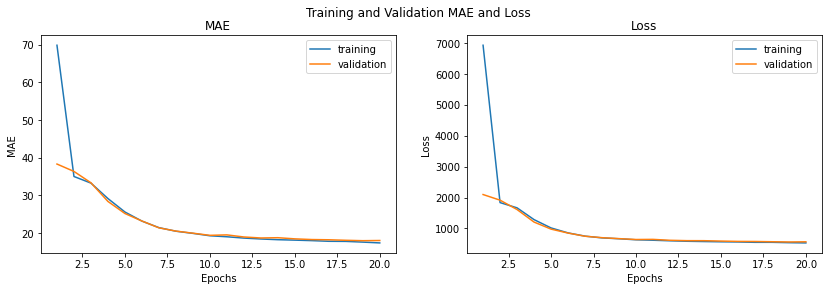

In [0]:
plot_history(trained_models['model_1']['result'])
model_params_results('model_1')

In [0]:
trained_models = train_and_save('model_2')

Epoch 1/20
 - 226s - loss: 16095.2749 - mean_absolute_error: 119.9243 - val_loss: 14688.3593 - val_mean_absolute_error: 113.9446
Epoch 2/20
 - 203s - loss: 12617.0863 - mean_absolute_error: 104.4101 - val_loss: 11546.7729 - val_mean_absolute_error: 99.2178
Epoch 3/20
 - 212s - loss: 9578.3878 - mean_absolute_error: 89.1690 - val_loss: 8854.4782 - val_mean_absolute_error: 85.3510
Epoch 4/20
 - 214s - loss: 7001.9403 - mean_absolute_error: 74.4282 - val_loss: 6611.9038 - val_mean_absolute_error: 72.2203
Epoch 5/20
 - 205s - loss: 5072.5507 - mean_absolute_error: 62.1339 - val_loss: 4959.4754 - val_mean_absolute_error: 61.4371
Epoch 6/20
 - 204s - loss: 3636.6069 - mean_absolute_error: 51.8236 - val_loss: 3712.7057 - val_mean_absolute_error: 52.3317
Epoch 7/20
 - 204s - loss: 2762.1267 - mean_absolute_error: 44.8536 - val_loss: 2979.3350 - val_mean_absolute_error: 46.3914
Epoch 8/20
 - 203s - loss: 2272.1723 - mean_absolute_error: 40.5135 - val_loss: 2504.5946 - val_mean_absolute_error: 4

Parameters of model_2: {'trainable': 'none', 'dense_hidden_neurons': 16, 'lr': 0.0001}
Best validation loss loss of model_2: 1429.5
Best validation MAE of model_2: 31.31 months


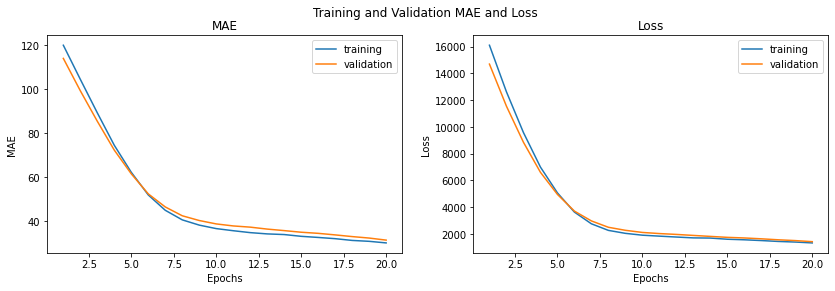

In [0]:
plot_history(trained_models['model_2']['result'])
model_params_results('model_2')

In [0]:
trained_models = train_and_save('model_3')

Epoch 1/20
 - 222s - loss: 5087.3478 - mean_absolute_error: 57.2059 - val_loss: 2021.2793 - val_mean_absolute_error: 37.3434
Epoch 2/20
 - 201s - loss: 1747.8285 - mean_absolute_error: 34.1342 - val_loss: 1738.4738 - val_mean_absolute_error: 34.4918
Epoch 3/20
 - 208s - loss: 1468.3026 - mean_absolute_error: 31.2068 - val_loss: 1413.8031 - val_mean_absolute_error: 31.0720
Epoch 4/20
 - 209s - loss: 1173.7940 - mean_absolute_error: 27.7096 - val_loss: 1156.1573 - val_mean_absolute_error: 27.7200
Epoch 5/20
 - 209s - loss: 957.5318 - mean_absolute_error: 24.7085 - val_loss: 925.0058 - val_mean_absolute_error: 24.2408
Epoch 6/20
 - 209s - loss: 826.2250 - mean_absolute_error: 22.6160 - val_loss: 807.3773 - val_mean_absolute_error: 22.3598
Epoch 7/20
 - 209s - loss: 736.8764 - mean_absolute_error: 21.1267 - val_loss: 784.6390 - val_mean_absolute_error: 21.9675
Epoch 8/20
 - 209s - loss: 701.5788 - mean_absolute_error: 20.5073 - val_loss: 689.4492 - val_mean_absolute_error: 20.2179
Epoch 9/

Parameters of model_3: {'trainable': 'none', 'dense_hidden_neurons': 32, 'lr': 0.001}
Best validation loss loss of model_3: 501.36
Best validation MAE of model_3: 16.77 months


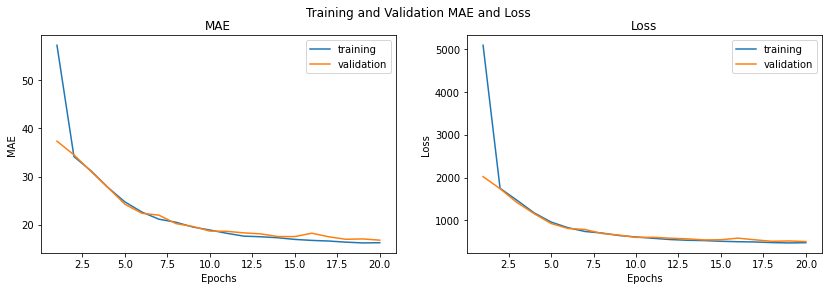

In [0]:
plot_history(trained_models['model_3']['result'])
model_params_results('model_3')

In [0]:
trained_models = train_and_save('model_4')

Epoch 1/20
 - 187s - loss: 15884.0508 - mean_absolute_error: 118.9259 - val_loss: 14085.8103 - val_mean_absolute_error: 111.1982
Epoch 2/20
 - 173s - loss: 11777.0511 - mean_absolute_error: 100.2928 - val_loss: 10494.9100 - val_mean_absolute_error: 93.9813
Epoch 3/20
 - 175s - loss: 8315.1000 - mean_absolute_error: 82.0920 - val_loss: 7461.4272 - val_mean_absolute_error: 77.3498
Epoch 4/20
 - 175s - loss: 5594.9541 - mean_absolute_error: 65.4994 - val_loss: 5166.7324 - val_mean_absolute_error: 62.8171
Epoch 5/20
 - 175s - loss: 3738.4857 - mean_absolute_error: 52.5760 - val_loss: 3660.0161 - val_mean_absolute_error: 51.8741
Epoch 6/20
 - 175s - loss: 2690.5886 - mean_absolute_error: 44.2231 - val_loss: 2807.7454 - val_mean_absolute_error: 45.0024
Epoch 7/20
 - 179s - loss: 2176.4503 - mean_absolute_error: 39.4955 - val_loss: 2390.9017 - val_mean_absolute_error: 41.2651
Epoch 8/20
 - 183s - loss: 1979.5008 - mean_absolute_error: 37.2156 - val_loss: 2200.0120 - val_mean_absolute_error: 3

Parameters of model_4: {'trainable': 'none', 'dense_hidden_neurons': 32, 'lr': 0.0001}
Best validation loss loss of model_4: 1330.92
Best validation MAE of model_4: 30.05 months


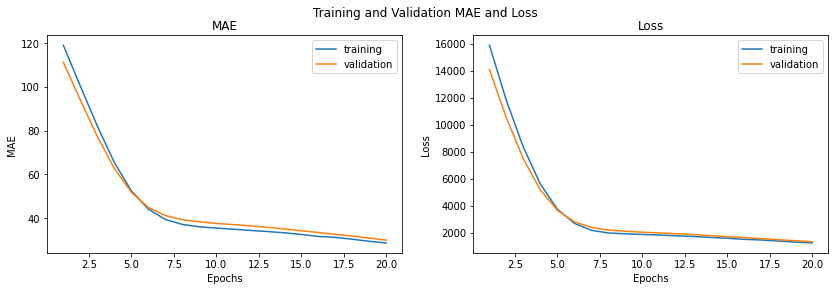

In [0]:
plot_history(trained_models['model_4']['result'])
model_params_results('model_4')

In [0]:
trained_models = train_and_save('model_5')

Epoch 1/20
 - 196s - loss: 3616.9945 - mean_absolute_error: 43.1610 - val_loss: 542.0329 - val_mean_absolute_error: 18.6562
Epoch 2/20
 - 179s - loss: 519.6100 - mean_absolute_error: 18.1392 - val_loss: 510.0544 - val_mean_absolute_error: 17.9741
Epoch 3/20
 - 184s - loss: 490.3199 - mean_absolute_error: 17.4563 - val_loss: 535.8134 - val_mean_absolute_error: 18.2139
Epoch 4/20
 - 185s - loss: 432.8527 - mean_absolute_error: 16.4024 - val_loss: 439.7865 - val_mean_absolute_error: 16.4278
Epoch 5/20
 - 185s - loss: 422.4629 - mean_absolute_error: 16.1616 - val_loss: 444.3647 - val_mean_absolute_error: 16.3807
Epoch 6/20
 - 187s - loss: 384.1200 - mean_absolute_error: 15.4348 - val_loss: 530.9320 - val_mean_absolute_error: 18.1823
Epoch 7/20
 - 188s - loss: 364.2705 - mean_absolute_error: 14.9247 - val_loss: 386.7030 - val_mean_absolute_error: 15.2184
Epoch 8/20
 - 187s - loss: 334.9380 - mean_absolute_error: 14.1963 - val_loss: 332.4275 - val_mean_absolute_error: 13.7880
Epoch 9/20
 - 1

Parameters of model_5: {'trainable': 'last_conv_layer', 'dense_hidden_neurons': 16, 'lr': 0.001}
Best validation loss loss of model_5: 274.76
Best validation MAE of model_5: 12.44 months


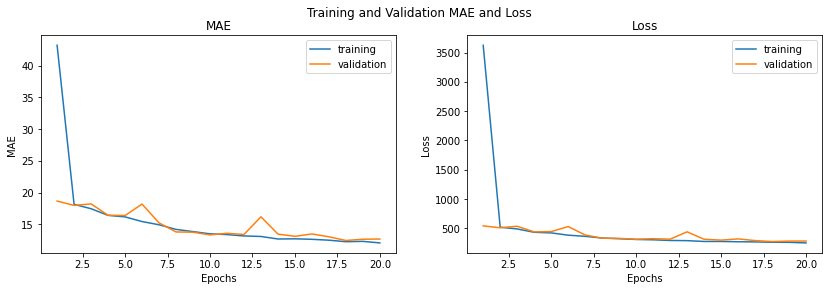

In [0]:
plot_history(trained_models['model_5']['result'])
model_params_results('model_5')

In [0]:
trained_models = train_and_save('model_6')

Epoch 1/20
 - 194s - loss: 15714.0692 - mean_absolute_error: 118.6178 - val_loss: 14674.5532 - val_mean_absolute_error: 114.4110
Epoch 2/20
 - 179s - loss: 12303.8359 - mean_absolute_error: 104.7976 - val_loss: 11144.0999 - val_mean_absolute_error: 99.8067
Epoch 3/20
 - 185s - loss: 8577.2658 - mean_absolute_error: 87.0579 - val_loss: 6114.9786 - val_mean_absolute_error: 72.6720
Epoch 4/20
 - 185s - loss: 5054.7524 - mean_absolute_error: 65.3347 - val_loss: 3185.1706 - val_mean_absolute_error: 50.6076
Epoch 5/20
 - 187s - loss: 2700.2810 - mean_absolute_error: 45.9142 - val_loss: 1481.7441 - val_mean_absolute_error: 32.5118
Epoch 6/20
 - 187s - loss: 1313.7323 - mean_absolute_error: 30.1199 - val_loss: 806.7797 - val_mean_absolute_error: 23.0500
Epoch 7/20
 - 187s - loss: 734.7687 - mean_absolute_error: 21.7855 - val_loss: 591.3600 - val_mean_absolute_error: 19.4954
Epoch 8/20
 - 185s - loss: 561.6690 - mean_absolute_error: 18.7797 - val_loss: 539.1728 - val_mean_absolute_error: 18.391

Parameters of model_6: {'trainable': 'last_conv_layer', 'dense_hidden_neurons': 16, 'lr': 0.0001}
Best validation loss loss of model_6: 446.63
Best validation MAE of model_6: 16.67 months


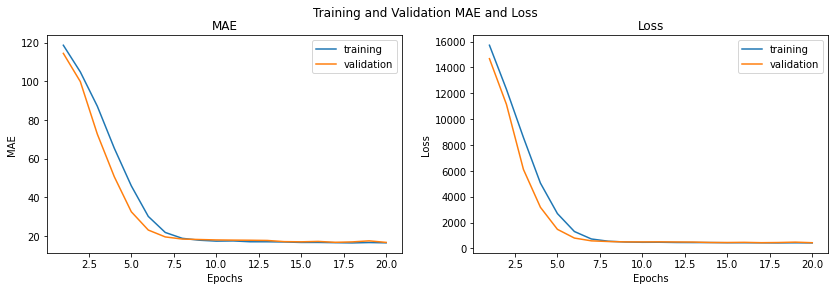

In [0]:
plot_history(trained_models['model_6']['result'])
model_params_results('model_6')

In [0]:
trained_models = train_and_save('model_7')

Epoch 1/20
 - 198s - loss: 3455.8244 - mean_absolute_error: 41.2166 - val_loss: 567.6483 - val_mean_absolute_error: 18.8970
Epoch 2/20
 - 183s - loss: 508.8083 - mean_absolute_error: 17.7878 - val_loss: 538.0367 - val_mean_absolute_error: 18.3225
Epoch 3/20
 - 185s - loss: 475.0010 - mean_absolute_error: 17.1299 - val_loss: 449.7875 - val_mean_absolute_error: 16.5229
Epoch 4/20
 - 184s - loss: 437.2141 - mean_absolute_error: 16.4576 - val_loss: 445.3093 - val_mean_absolute_error: 16.5192
Epoch 5/20
 - 184s - loss: 414.5414 - mean_absolute_error: 15.8429 - val_loss: 521.9704 - val_mean_absolute_error: 17.8166
Epoch 6/20
 - 184s - loss: 385.5567 - mean_absolute_error: 15.2066 - val_loss: 422.0555 - val_mean_absolute_error: 15.9550
Epoch 7/20
 - 185s - loss: 353.0315 - mean_absolute_error: 14.5702 - val_loss: 353.1765 - val_mean_absolute_error: 14.3526
Epoch 8/20
 - 185s - loss: 334.9970 - mean_absolute_error: 14.0431 - val_loss: 318.9645 - val_mean_absolute_error: 13.4553
Epoch 9/20
 - 1

Parameters of model_7: {'trainable': 'last_conv_layer', 'dense_hidden_neurons': 32, 'lr': 0.001}
Best validation loss loss of model_7: 268.74
Best validation MAE of model_7: 12.21 months


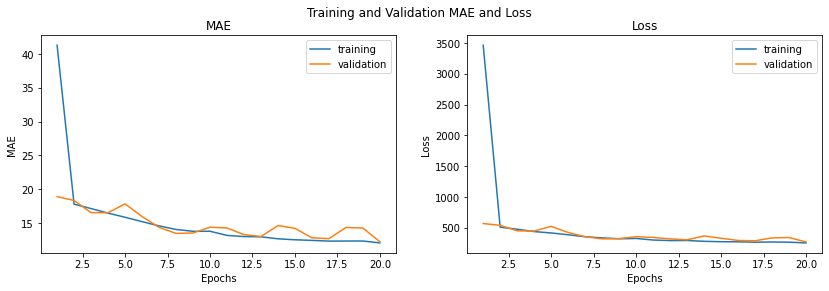

In [0]:
plot_history(trained_models['model_7']['result'])
model_params_results('model_7')

In [0]:
trained_models = train_and_save('model_8')

Epoch 1/20
 - 187s - loss: 15007.5736 - mean_absolute_error: 115.6867 - val_loss: 12874.5531 - val_mean_absolute_error: 106.9619
Epoch 2/20
 - 171s - loss: 9370.6239 - mean_absolute_error: 90.2832 - val_loss: 6680.5085 - val_mean_absolute_error: 75.8687
Epoch 3/20
 - 175s - loss: 4529.7505 - mean_absolute_error: 61.0142 - val_loss: 2398.4179 - val_mean_absolute_error: 43.0091
Epoch 4/20
 - 175s - loss: 1708.7832 - mean_absolute_error: 34.8196 - val_loss: 980.6558 - val_mean_absolute_error: 25.5533
Epoch 5/20
 - 176s - loss: 746.1204 - mean_absolute_error: 21.8899 - val_loss: 612.1665 - val_mean_absolute_error: 19.9273
Epoch 6/20
 - 176s - loss: 554.6358 - mean_absolute_error: 18.6360 - val_loss: 570.8679 - val_mean_absolute_error: 19.1135
Epoch 7/20
 - 176s - loss: 512.6306 - mean_absolute_error: 17.9741 - val_loss: 547.2576 - val_mean_absolute_error: 18.5540
Epoch 8/20
 - 175s - loss: 503.9868 - mean_absolute_error: 17.6999 - val_loss: 511.3652 - val_mean_absolute_error: 18.0873
Epoch

Parameters of model_8: {'trainable': 'last_conv_layer', 'dense_hidden_neurons': 32, 'lr': 0.0001}
Best validation loss loss of model_8: 450.38
Best validation MAE of model_8: 16.75 months


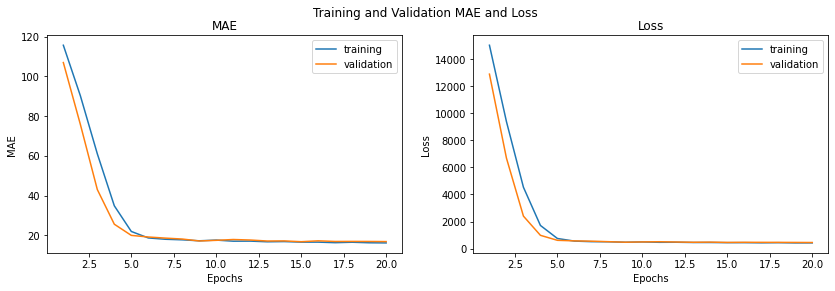

In [0]:
plot_history(trained_models['model_8']['result'])
model_params_results('model_8')

In [0]:
trained_models = train_and_save('model_9')

Epoch 1/20
 - 189s - loss: 3155.3945 - mean_absolute_error: 39.2171 - val_loss: 383.4923 - val_mean_absolute_error: 15.3708
Epoch 2/20
 - 171s - loss: 362.5417 - mean_absolute_error: 15.0049 - val_loss: 352.8004 - val_mean_absolute_error: 14.5630
Epoch 3/20
 - 176s - loss: 337.7368 - mean_absolute_error: 14.4797 - val_loss: 364.6456 - val_mean_absolute_error: 14.9051
Epoch 4/20
 - 176s - loss: 313.0225 - mean_absolute_error: 13.9588 - val_loss: 443.8850 - val_mean_absolute_error: 16.9098
Epoch 5/20
 - 176s - loss: 296.8178 - mean_absolute_error: 13.5059 - val_loss: 274.9740 - val_mean_absolute_error: 13.0116
Epoch 6/20
 - 176s - loss: 282.7277 - mean_absolute_error: 13.0545 - val_loss: 271.5205 - val_mean_absolute_error: 12.9256
Epoch 7/20
 - 176s - loss: 258.0823 - mean_absolute_error: 12.5072 - val_loss: 310.8605 - val_mean_absolute_error: 14.0540
Epoch 8/20
 - 176s - loss: 245.6417 - mean_absolute_error: 12.0955 - val_loss: 262.5549 - val_mean_absolute_error: 12.6362
Epoch 9/20
 - 1

Parameters of model_9: {'trainable': 'stage4_unit2', 'dense_hidden_neurons': 16, 'lr': 0.001}
Best validation loss loss of model_9: 204.17
Best validation MAE of model_9: 10.76 months


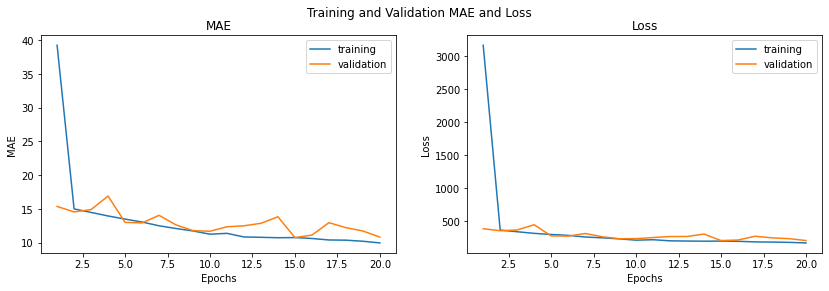

In [0]:
plot_history(trained_models['model_9']['result'])
model_params_results('model_9')

In [0]:
trained_models = train_and_save('model_10')

Epoch 1/20
 - 187s - loss: 14591.6242 - mean_absolute_error: 114.7246 - val_loss: 9713.8963 - val_mean_absolute_error: 94.1702
Epoch 2/20
 - 172s - loss: 9292.0523 - mean_absolute_error: 91.7905 - val_loss: 4632.1083 - val_mean_absolute_error: 63.7487
Epoch 3/20
 - 174s - loss: 4905.3992 - mean_absolute_error: 65.5256 - val_loss: 2684.5690 - val_mean_absolute_error: 47.2694
Epoch 4/20
 - 174s - loss: 2023.8333 - mean_absolute_error: 39.9887 - val_loss: 1374.5758 - val_mean_absolute_error: 32.2442
Epoch 5/20
 - 175s - loss: 760.1582 - mean_absolute_error: 22.7728 - val_loss: 707.9211 - val_mean_absolute_error: 21.8690
Epoch 6/20
 - 175s - loss: 400.7542 - mean_absolute_error: 15.8281 - val_loss: 377.4818 - val_mean_absolute_error: 15.4101
Epoch 7/20
 - 175s - loss: 330.1021 - mean_absolute_error: 14.2785 - val_loss: 443.8025 - val_mean_absolute_error: 16.9293
Epoch 8/20
 - 176s - loss: 313.5312 - mean_absolute_error: 13.8825 - val_loss: 360.9271 - val_mean_absolute_error: 15.0627
Epoch 

Parameters of model_10: {'trainable': 'stage4_unit2', 'dense_hidden_neurons': 16, 'lr': 0.0001}
Best validation loss loss of model_10: 287.04
Best validation MAE of model_10: 13.29 months


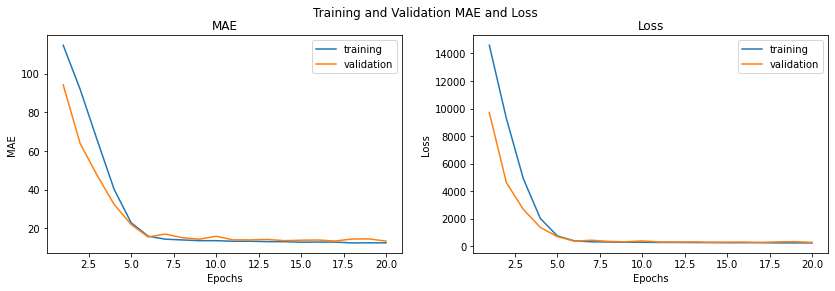

In [0]:
plot_history(trained_models['model_10']['result'])
model_params_results('model_10')

In [0]:
trained_models = train_and_save('model_11')

Epoch 1/20
 - 187s - loss: 3636.0553 - mean_absolute_error: 42.6883 - val_loss: 458.3875 - val_mean_absolute_error: 16.7518
Epoch 2/20
 - 171s - loss: 372.7650 - mean_absolute_error: 15.0748 - val_loss: 404.0191 - val_mean_absolute_error: 15.8938
Epoch 3/20
 - 176s - loss: 335.3608 - mean_absolute_error: 14.2265 - val_loss: 403.1059 - val_mean_absolute_error: 15.8478
Epoch 4/20
 - 174s - loss: 306.7682 - mean_absolute_error: 13.6072 - val_loss: 309.8131 - val_mean_absolute_error: 13.7441
Epoch 5/20
 - 174s - loss: 277.1584 - mean_absolute_error: 12.8552 - val_loss: 321.1789 - val_mean_absolute_error: 13.8751
Epoch 6/20
 - 174s - loss: 261.8982 - mean_absolute_error: 12.4716 - val_loss: 294.7167 - val_mean_absolute_error: 13.2081
Epoch 7/20
 - 174s - loss: 250.7128 - mean_absolute_error: 12.1712 - val_loss: 267.2576 - val_mean_absolute_error: 12.5983
Epoch 8/20
 - 175s - loss: 238.8534 - mean_absolute_error: 11.8073 - val_loss: 243.8633 - val_mean_absolute_error: 11.8863
Epoch 9/20
 - 1

Parameters of model_11: {'trainable': 'stage4_unit2', 'dense_hidden_neurons': 32, 'lr': 0.001}
Best validation loss loss of model_11: 199.64
Best validation MAE of model_11: 10.59 months


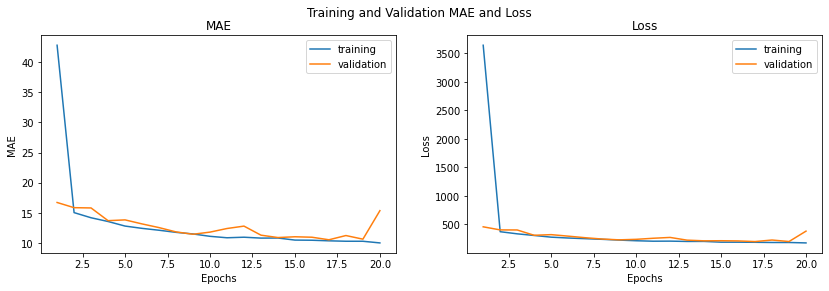

In [0]:
plot_history(trained_models['model_11']['result'])
model_params_results('model_11')

In [0]:
trained_models = train_and_save('model_12')

Epoch 1/20
 - 193s - loss: 13228.7614 - mean_absolute_error: 108.7857 - val_loss: 7715.8980 - val_mean_absolute_error: 82.9221
Epoch 2/20
 - 184s - loss: 6466.2974 - mean_absolute_error: 75.1050 - val_loss: 2561.3178 - val_mean_absolute_error: 44.9225
Epoch 3/20
 - 183s - loss: 2134.7198 - mean_absolute_error: 40.2985 - val_loss: 939.1499 - val_mean_absolute_error: 25.3484
Epoch 4/20
 - 185s - loss: 576.8773 - mean_absolute_error: 19.0869 - val_loss: 568.8567 - val_mean_absolute_error: 19.2126
Epoch 5/20
 - 185s - loss: 354.2379 - mean_absolute_error: 14.8195 - val_loss: 478.3392 - val_mean_absolute_error: 17.4303
Epoch 6/20
 - 183s - loss: 321.2514 - mean_absolute_error: 14.0065 - val_loss: 341.2315 - val_mean_absolute_error: 14.5261
Epoch 7/20
 - 182s - loss: 319.0511 - mean_absolute_error: 14.0105 - val_loss: 337.4039 - val_mean_absolute_error: 14.3723
Epoch 8/20
 - 181s - loss: 302.6125 - mean_absolute_error: 13.5922 - val_loss: 364.6873 - val_mean_absolute_error: 15.1226
Epoch 9/2

Parameters of model_12: {'trainable': 'stage4_unit2', 'dense_hidden_neurons': 32, 'lr': 0.0001}
Best validation loss loss of model_12: 275.37
Best validation MAE of model_12: 12.97 months


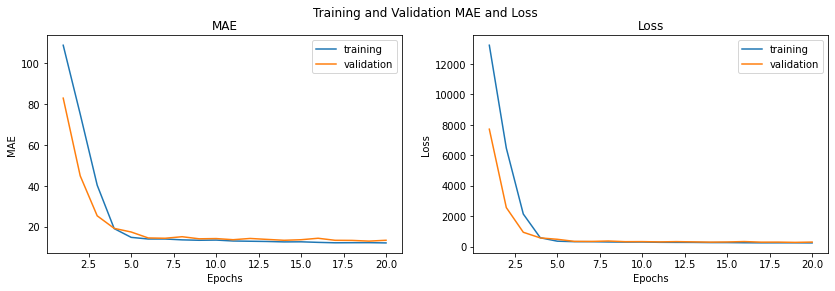

In [0]:
plot_history(trained_models['model_12']['result'])
model_params_results('model_12')

### Evaluate best model

In [0]:
best_val_mae = np.min([info['result']['val_mean_absolute_error'] 
                       for model, info in trained_models.items()])
best_model_nr = [model for model, info in trained_models.items() 
                 if np.min(info['result']['val_mean_absolute_error'])==best_val_mae][0]

In [0]:
best_model = load_model('keras_weights_{}.hdf5'.format(best_model_nr))

In [0]:
result = best_model.evaluate_generator(test_generator, steps=1)
print('The final model achieves a MAE of {} on the test set.'.format(round(result[1],2)))
print('The final model achieves a MSE of {} on the test set.'.format(round(result[0],2)))

The final model achieves a MAE of 11.7 on the test set.
The final model achieves a MSE of 232.31 on the test set.


#### Plot some test images

In [0]:
test_generator = custom_generator(test, 200, datagen, 'test', shuffle=False)
y_hats = best_model.predict_generator(test_generator, steps=1)
y_true = test['boneage'].values

In [0]:
mean_absolute_error(y_true, y_hats)

11.701538105010986

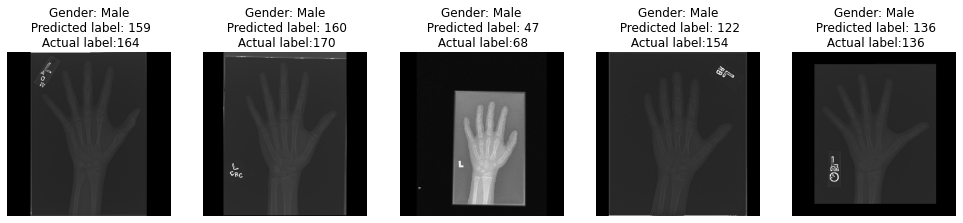

In [0]:
test_images = []
for i in range(5):
    test_image = krs_image.load_img(test.iloc[i,2], target_size=(256, 256))
    test_image = krs_image.img_to_array(test_image)
    test_image = test_image * (1./255)
    test_images.append(test_image)

fig, axes = plt.subplots(1, len(test_images), figsize=(17, 5))
for idx, ax in enumerate(axes):
    ax.axis('off')
    ax.imshow(test_images[idx])
    ax.set_title('Gender: {}\n Predicted label: {}\n Actual label:{}'.format(
        'Male' if test.iloc[idx, 4]==1 else 'Female',
        int(round(y_hats[idx][0])), 
        y_true[idx]))